In [44]:
import socket
import matplotlib.pyplot as plt
import time
import numpy as np
import sounddevice as sd
from scipy.signal import blackman
import csv

In [45]:
import csv
from datetime import datetime

def save_waveform_data(timestamps, data, base_file_name="waveform_data"):
    """Save the waveform data to a CSV file with a name based on the current date and time.

    Parameters:
    - timestamps: A list of timestamp values.
    - data: A list of amplifier data values.
    - base_file_name: The base name of the file to save the data to, without extension.
    """
    # Get the current date and time, formatted as 'YYYY-MM-DD_HH-MM-SS'
    current_time_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # Create the file name by appending the current time to the base file name
    file_name = f"{base_file_name}_{current_time_str}.csv"
    
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Timestamp (s)', 'Voltage (uV)'])  # Write header
        for timestamp, voltage in zip(timestamps, data):
            writer.writerow([timestamp, voltage])
    
    print(f'Data successfully saved to {file_name}')

# Example usage
# Assuming amplifierTimestamps and amplifierData contain your data
# save_waveform_data(amplifierTimestamps, amplifierData)



In [46]:
def generate_sound(sel):
    """Generate a sound based on selection."""
    t = np.linspace(0, DURATION, int(Fs * DURATION), endpoint=False)
    if sel == 1:  # Blackman filtered sine
        frequency = 440  # Example frequency
        sound = np.sin(2 * np.pi * frequency * t) * np.blackman(len(t))
    elif sel == 2:  # Blackman filtered Gaussian
        sound = np.random.normal(0, 1, len(t)) * np.blackman(len(t))
    elif sel == 3:  # Plain Gaussian
        sound = np.random.normal(0, 1, len(t))
    elif sel == 4:  # Homophasic-Antiphasic
        sound = np.sin(2 * np.pi * 440 * t) - np.sin(2 * np.pi * 440 * t + np.pi)
    else:
        raise ValueError("Selection must be between 1 and 4.")
    return sound

import random

def play_sound_sel(sel, sound_events, elapsed_time, Fs=44100):
    """Play the selected sound."""
    channel = random.choice([1, 2, 3])  # 1=left, 2=right, 3=silence
    sound_mono = generate_sound(sel)
    if channel == 1:  # Left
        sound_stereo = np.column_stack((sound_mono, np.zeros(len(sound_mono))))
    elif channel == 2:  # Right
        sound_stereo = np.column_stack((np.zeros(len(sound_mono)), sound_mono))
    else:  # Silence
        sound_stereo = np.column_stack((np.zeros(len(sound_mono)), np.zeros(len(sound_mono))))
    
    sound_events.append({'time': elapsed_time, 'sound': sel, 'channel': channel})
    sd.play(sound_stereo, Fs)
    sd.wait()
    
    


def save_sound_events(sound_events, file_name='sound_events.csv'):
    # Get the current date and time, formatted as 'YYYY-MM-DD_HH-MM-SS'
    current_time_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # Create the file name by appending the current time to the base file name
    file_name = f"sound_{current_time_str}.csv"
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Time (s)', 'Sound Selection'])
        for event in sound_events:
            writer.writerow([event['time'], event['sound']])
    print(f'Sound Data successfully saved to {file_name}')    


In [47]:
#! /bin/env python3
# Adrian Foy September 2023

"""Example demonstrating reading of 1 second waveform data (wideband amplifier
data on channel A-010) using TCP command socket to control RHX software and TCP
waveform socket to read amplifier data.

In order to run this example script successfully, the Intan RHX software
should first be started, and through Network -> Remote TCP Control.

Command Output should open a connection at 127.0.0.1, Port 5000.
Status should read "Pending".

Waveform Output (in the Data Output tab) should open a connection at 127.0.0.1,
Port 5001. Status should read "Pending" for the Waveform Port (Spike Port is
unused for this example, and can be left disconnected).

Once these ports are opened, this script can be run to acquire ~1 second of
wideband data from channel A-010, which can then be plotted assuming
"matplotlib" is installed.
"""

import time
import socket
import numpy as np
# In order to plot the data, 'matplotlib' is required.
# If plotting is not needed, calls to plt can be removed and the data
# will still be present within the ReadWaveformDataDemo() function.
# 'matplotlib' can be installed with the command 'pip install matplotlib'
import matplotlib.pyplot as plt


def readUint32(data, index):
    # Assuming data is a bytes or bytearray object
    result = int.from_bytes(data[index:index+4], byteorder='little', signed=False)
    return result, index + 4

def readInt32(data, index):
    result = int.from_bytes(data[index:index+4], byteorder='little', signed=True)
    return result, index + 4

def readUint16(data, index):
    result = int.from_bytes(data[index:index+2], byteorder='little', signed=False)
    return result, index + 2


In [48]:


def ReadWaveformDataDemo(sound_selection, repeats, interval, recording_dur, start_delay=10 ):
    
    """Read Waveform Data Demo.

    Uses TCP to control RHX software and read 1 second of waveform data,
    as a demonstration of TCP control and TCP data streaming, both of which
    are described in 'IntanRHX_TCPDocumentation.pdf'
    """

    # Connect to TCP command server - default home IP address at port 5000.
    print('Connecting to TCP command server...')
    scommand = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    scommand.connect(('127.0.0.1', 5000))

    # Connect to TCP waveform server - default home IP address at port 5001.
    print('Connecting to TCP waveform server...')
    swaveform = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    swaveform.connect(('127.0.0.1', 5001))

    # Query runmode from RHX software.
    scommand.sendall(b'get runmode')
    commandReturn = str(scommand.recv(COMMAND_BUFFER_SIZE), "utf-8")

    # If controller is running, stop it.
    if commandReturn != "Return: RunMode Stop":
        scommand.sendall(b'set runmode stop')
        # Allow time for RHX software to accept this command before the next.
        time.sleep(0.1)

    # Query sample rate from RHX software.
    scommand.sendall(b'get sampleratehertz')
    commandReturn = str(scommand.recv(COMMAND_BUFFER_SIZE), "utf-8")
    expectedReturnString = "Return: SampleRateHertz "
    # Look for "Return: SampleRateHertz N" where N is the sample rate.
    if commandReturn.find(expectedReturnString) == -1:
        raise GetSampleRateFailure(
            'Unable to get sample rate from server.'
        )

    # Calculate timestep from sample rate.
    timestep = 1 / float(commandReturn[len(expectedReturnString):])

    # Clear TCP data output to ensure no TCP channels are enabled.
    scommand.sendall(b'execute clearalldataoutputs')
    time.sleep(0.1)

    #OLD CODE  # Send TCP commands to set up TCP Data Output Enabled for wide
    # band of channel A-010.
    scommand.sendall(b'set a-010.tcpdataoutputenabled true')
    time.sleep(0.1)

    # Update calculations for 30 seconds of data
    # If sample rate is X Hz, then for 30 seconds, the frames would be 30*X.
    # You need to adjust the calculation of NumBlocks accordingly.

    #FRAMES_PER_BLOCK = 128  # Assuming this is defined and constant
    waveformBytesPerFrame = 4 + 2  # 4 bytes for timestamp, 2 bytes for sample
    SizeOfMagicNumber = 4
    # Calculate NumBlocks for 30 seconds of data, considering the sample rate
    sampleRate = float(commandReturn[len(expectedReturnString):])  # Extracted from the command return
    NumFrames = 30 * sampleRate  # Total frames in 30 seconds
    NumBlocks = int((NumFrames + FRAMES_PER_BLOCK - 1) / FRAMES_PER_BLOCK)  # Round up to the nearest whole block
    waveformBytesPerBlock = FRAMES_PER_BLOCK * waveformBytesPerFrame + SizeOfMagicNumber

    
    # Start recording (data collection)
    print('Starting data collection...')
    scommand.sendall(b'set runmode run')
    elapsed = 0
    sound_events = []  # Initialize list to record sound playback events
    time.sleep(start_delay)  # Wait for start_delay seconds before playing sounds
    
    # Now start the sound playback logic
    start_playback_time = time.time()
    for i in range(repeats):
        elapsed_time = time.time() - start_playback_time
        play_sound_sel(sound_selection, sound_events, elapsed_time)
        time.sleep(interval)
    # Stop recording after the final sound playback and interval wait
    scommand.sendall(b'set runmode stop')


    # Modify the section for reading and processing the waveform data
    rawData = swaveform.recv(WAVEFORM_BUFFER_SIZE)
    numCompleteBlocks = len(rawData) // waveformBytesPerBlock

    amplifierTimestamps = []
    amplifierData = []
    rawIndex = 0

    for _ in range(numCompleteBlocks):
        # Process each complete block
        if rawIndex + waveformBytesPerBlock <= len(rawData):
            # Read magic number
            magicNumber, rawIndex = readUint32(rawData, rawIndex)
            if magicNumber != 0x2ef07a08:
                raise InvalidMagicNumber('Error... magic number incorrect')
            
            for _ in range(FRAMES_PER_BLOCK):
                # Read timestamp and sample data for each frame in the block
                rawTimestamp, rawIndex = readInt32(rawData, rawIndex)
                amplifierTimestamps.append(rawTimestamp * timestep)
                
                rawSample, rawIndex = readUint16(rawData, rawIndex)
                amplifierData.append(0.195 * (rawSample - 32768))
        else:
            # If the remaining data is not enough for a complete block, break the loop
            print("Incomplete block received at the end or data format mismatch.")
            break
    
    # If using matplotlib to plot is not desired,
    # the following plot lines can be removed.
    # Data is still accessible at this point in the amplifierTimestamps
    # and amplifierData.
    plt.plot(amplifierTimestamps, amplifierData)
    plt.title('A-010 Amplifier Data')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (uV)')
    plt.show()
    save_waveform_data(amplifierTimestamps, amplifierData)
    save_sound_events(sound_events)

    
class GetSampleRateFailure(Exception):
    """Exception returned when the TCP socket failed to yield the sample rate
    as reported by the RHX software.
    """


class InvalidReceivedDataSize(Exception):
    """Exception returned when the amount of data received on the TCP socket
    is not an integer multiple of the excepted data block size.
    """


class InvalidMagicNumber(Exception):
    """Exception returned when the first 4 bytes of a data block are not the
    expected RHX TCP magic number (0x2ef07a08).
    """



Connecting to TCP command server...
Connecting to TCP waveform server...
Starting data collection...


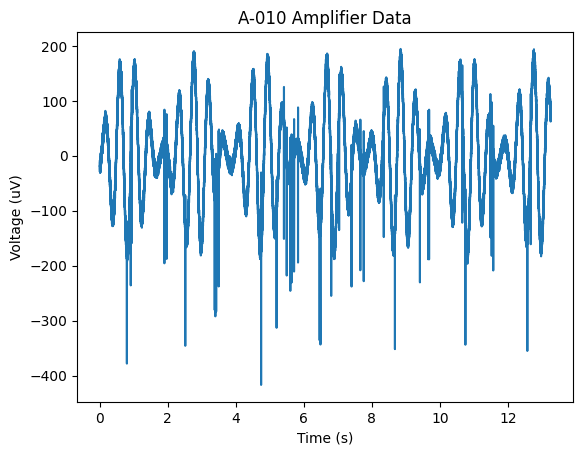

Data successfully saved to waveform_data_2024-03-04_20-17-47.csv
Sound Data successfully saved to sound_2024-03-04_20-17-47.csv


In [49]:

if __name__ == '__main__':
    # Declare buffer size for reading from TCP command socket.
    # This is the maximum number of bytes expected for 1 read. 1024 is plenty
    # for a single text command.
    # Increase if many return commands are expected.
    #COMMAND_BUFFER_SIZE = 1024

    # Declare buffer size for reading from TCP waveform socket.
    # This is the maximum number of bytes expected for 1 read.

    # There will be some TCP lag in both starting and stopping acquisition,
    # so the exact number of data blocks may vary slightly.
    # At 30 kHz with 1 channel, 1 second of wideband waveform data is
    # 181,420 byte. See 'Calculations for accurate parsing' for more details.
    # To allow for some TCP lag in stopping acquisition resulting in slightly
    # more than 1 second of data, 200000 should be a safe buffer size.
    # Increase if channels, filter bands, or acquisition time increase.
    #WAVEFORM_BUFFER_SIZE = 400000

    # RHX software is hard-coded to always handle data in blocks of 128 frames.
    # Constants
    Fs = 44100  # Sampling frequency
    DURATION = 1  # Duration of the sound in seconds
    COMMAND_BUFFER_SIZE = 1024 * 10 # Example size, adjust as necessary
    WAVEFORM_BUFFER_SIZE = 800000  # Adjust based on 30 seconds of data
    FRAMES_PER_BLOCK = 128
    sound_selection = 3  # Example sound selection
    repeats = 5  # Number of times to play the sound
    interval = 2  # Interval between sounds, in seconds
    timeRec = 10
    ReadWaveformDataDemo(sound_selection, repeats, interval, timeRec, start_delay=2)

In [ ]:
np.